## Prerequisites

To run the codes in this notebook, you need to install:

1. GridDB C Client
2. GridDB Python client

Follow the instructions on the [GridDB Python Package Index (Pypi)](https://pypi.org/project/griddb-python/) page to install these clients.

You will also need to install Numpy, Pandas and Seaborn libraries. 

The script below imports the libraries you will need to run the code in this blog.

In [2]:
import griddb_python as griddb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

## Importing and Preprocessing the World Population Dataset

In [7]:
# Dataset download link: https://www.kaggle.com/datasets/iamsouravbanerjee/world-population-dataset

dataset = pd.read_csv(r"/mnt/d/Datasets/world_population.csv")
print(dataset.shape)
dataset.head()


(234, 17)


,Rank,CCA3,Country/Territory,Capital,Continent,2022 Population,2020 Population,2015 Population,2010 Population,2000 Population,1990 Population,1980 Population,1970 Population,Area (km²),Density (per km²),Growth Rate,World Population Percentage
0,36,AFG,Afghanistan,Kabul,Asia,41128771,38972230,33753499,28189672,19542982,10694796,12486631,10752971,652230,63.0587,1.0257,0.52
1,138,ALB,Albania,Tirana,Europe,2842321,2866849,2882481,2913399,3182021,3295066,2941651,2324731,28748,98.8702,0.9957,0.04
2,34,DZA,Algeria,Algiers,Africa,44903225,43451666,39543154,35856344,30774621,25518074,18739378,13795915,2381741,18.8531,1.0164,0.56
3,213,ASM,American Samoa,Pago Pago,Oceania,44273,46189,51368,54849,58230,47818,32886,27075,199,222.4774,0.9831,0.00
4,203,AND,Andorra,Andorra la Vella,Europe,79824,77700,71746,71519,66097,53569,35611,19860,468,170.5641,1.0100,0.00


In [8]:
dataset.columns = dataset.columns.str.replace('[^a-zA-Z0-9]', '_', regex=True)
dataset.dtypes

Rank                             int64
CCA3                            object
Country_Territory               object
Capital                         object
Continent                       object
2022_Population                  int64
2020_Population                  int64
2015_Population                  int64
2010_Population                  int64
2000_Population                  int64
1990_Population                  int64
1980_Population                  int64
1970_Population                  int64
Area__km__                       int64
Density__per_km__              float64
Growth_Rate                    float64
World_Population_Percentage    float64
dtype: object

## Creating a Connection with GridDB

In [9]:
factory = griddb.StoreFactory.get_instance()

DB_HOST = "127.0.0.1:10001"
DB_CLUSTER = "myCluster"
DB_USER = "admin"
DB_PASS = "admin"

try:
    gridstore = factory.get_store(
        notification_member = DB_HOST,
        cluster_name = DB_CLUSTER,
        username = DB_USER,
        password = DB_PASS
    )

    container1 = gridstore.get_container("container1")
    if container1 == None:
        print("Container does not exist")
    print("Successfully connected to GridDB")

except griddb.GSException as e:
    for i in range(e.get_error_stack_size()):
        print("[", i, "]")
        print(e.get_error_code(i))
        print(e.get_location(i))
        print(e.get_message(i))

Container does not exist
Successfully connected to GridDB


## Storing World Population Data in a GridDB Container

In [10]:
# see all GridDB data types: https://docs.griddb.net/architecture/data-model/#data-type

def map_pandas_dtype_to_griddb(dtype):
    if dtype == 'int64':
        return griddb.Type.LONG
    elif dtype == 'float64':
        return griddb.Type.FLOAT
    elif dtype == 'object':
        return griddb.Type.STRING
    # Add more column types if you want
    else:
        raise ValueError(f'Unsupported pandas dtype: {dtype}')

container_columns = []
for column_name, dtype in dataset.dtypes.items():
    griddb_dtype = map_pandas_dtype_to_griddb(str(dtype))
    container_columns.append([column_name, griddb_dtype])

container_info = griddb.ContainerInfo("PopulationStats",
                                      container_columns,
                                      griddb.ContainerType.COLLECTION, True)

In [11]:
try:
    cont = gridstore.put_container(container_info)
    for index, row in dataset.iterrows():
        cont.put(row.tolist())
    print("All rows have been successfully stored in the GridDB container.")

except griddb.GSException as e:
    for i in range(e.get_error_stack_size()):
        print("[", i, "]")
        print(e.get_error_code(i))
        print(e.get_location(i))
        print(e.get_message(i))


All rows have been successfully stored in the GridDB container.


## Retrieving World Population Data From a GridDB Container

In [12]:
population_container = gridstore.get_container("PopulationStats")
query = population_container.query("select *")
rs = query.fetch()
population_data = rs.fetch_rows()

print(population_data.shape)
population_data.head()

(234, 17)


,Rank,CCA3,Country_Territory,Capital,Continent,2022_Population,2020_Population,2015_Population,2010_Population,2000_Population,1990_Population,1980_Population,1970_Population,Area__km__,Density__per_km__,Growth_Rate,World_Population_Percentage
0,36,AFG,Afghanistan,Kabul,Asia,41128771,38972230,33753499,28189672,19542982,10694796,12486631,10752971,652230,63.058701,1.0257,0.52
1,138,ALB,Albania,Tirana,Europe,2842321,2866849,2882481,2913399,3182021,3295066,2941651,2324731,28748,98.870201,0.9957,0.04
2,34,DZA,Algeria,Algiers,Africa,44903225,43451666,39543154,35856344,30774621,25518074,18739378,13795915,2381741,18.853100,1.0164,0.56
3,213,ASM,American Samoa,Pago Pago,Oceania,44273,46189,51368,54849,58230,47818,32886,27075,199,222.477402,0.9831,0.00
4,203,AND,Andorra,Andorra la Vella,Europe,79824,77700,71746,71519,66097,53569,35611,19860,468,170.564102,1.0100,0.00


## Visualizing World Population Data in Python using Data from GridDB

### Analyzing World Population by Continent

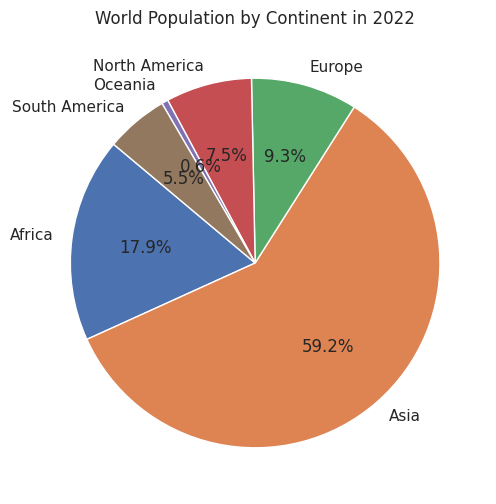

In [13]:
population_by_continent = population_data.groupby('Continent')['2022_Population'].sum()

plt.figure(figsize=(6,6))
plt.pie(population_by_continent,
        labels=population_by_continent.index,
        autopct='%1.1f%%', startangle=140)
plt.title('World Population by Continent in 2022')
plt.show()

### Visualizing Top 10 Countries by World Population Percentage

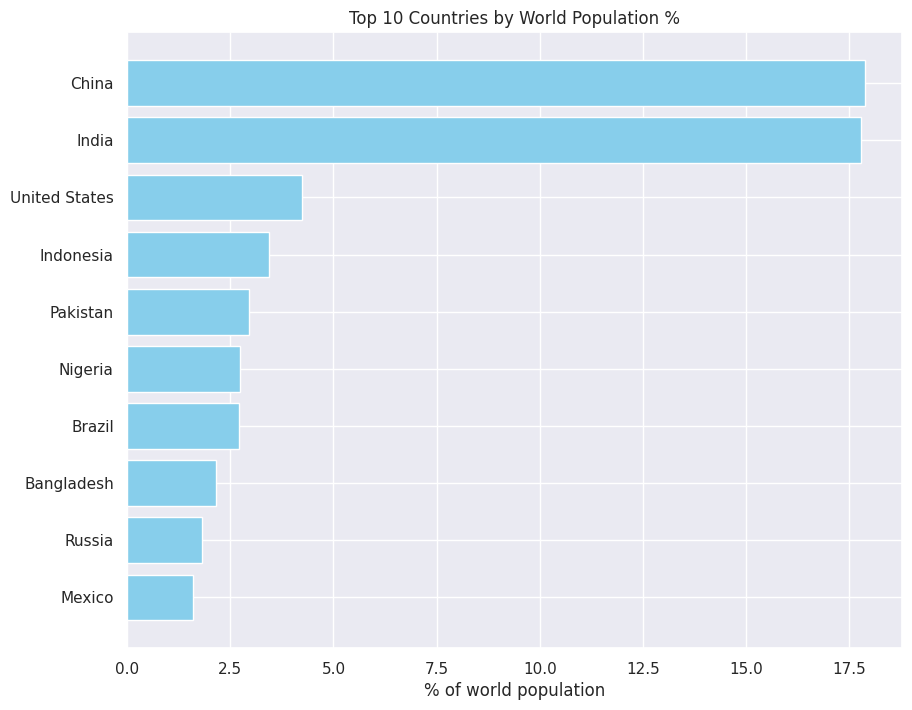

In [14]:
top_countries = population_data.sort_values('World_Population_Percentage', ascending=False).head(10)

plt.figure(figsize=(10, 8))
plt.barh(top_countries['Country_Territory'],
         top_countries['World_Population_Percentage'],
         color='skyblue')

plt.xlabel('% of world population')
plt.title('Top 10 Countries by World Population %')
plt.gca().invert_yaxis()  # Ensure the largest value is at the top
plt.show()

### Analyzing the Top 10 Most Dense Countries/Territories

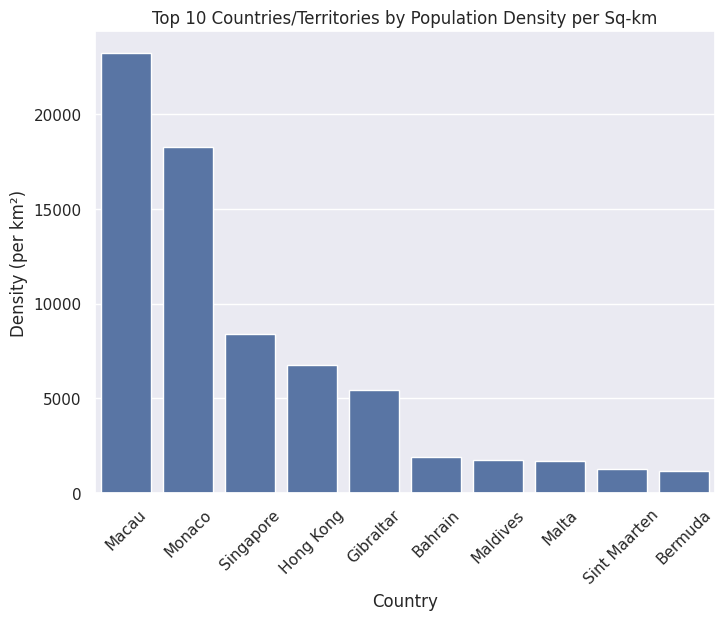

In [15]:
top_density_countries = population_data.nlargest(10, 'Density__per_km__')

plt.figure(figsize=(8, 6))
sns.barplot(x='Country_Territory', y='Density__per_km__', data=top_density_countries)
plt.xticks(rotation=45)
plt.title('Top 10 Countries/Territories by Population Density per Sq-km')
plt.xlabel('Country')
plt.ylabel('Density (per km²)')
plt.show()

### Top 10 Most Densely Populated Countries in Europe and Asia

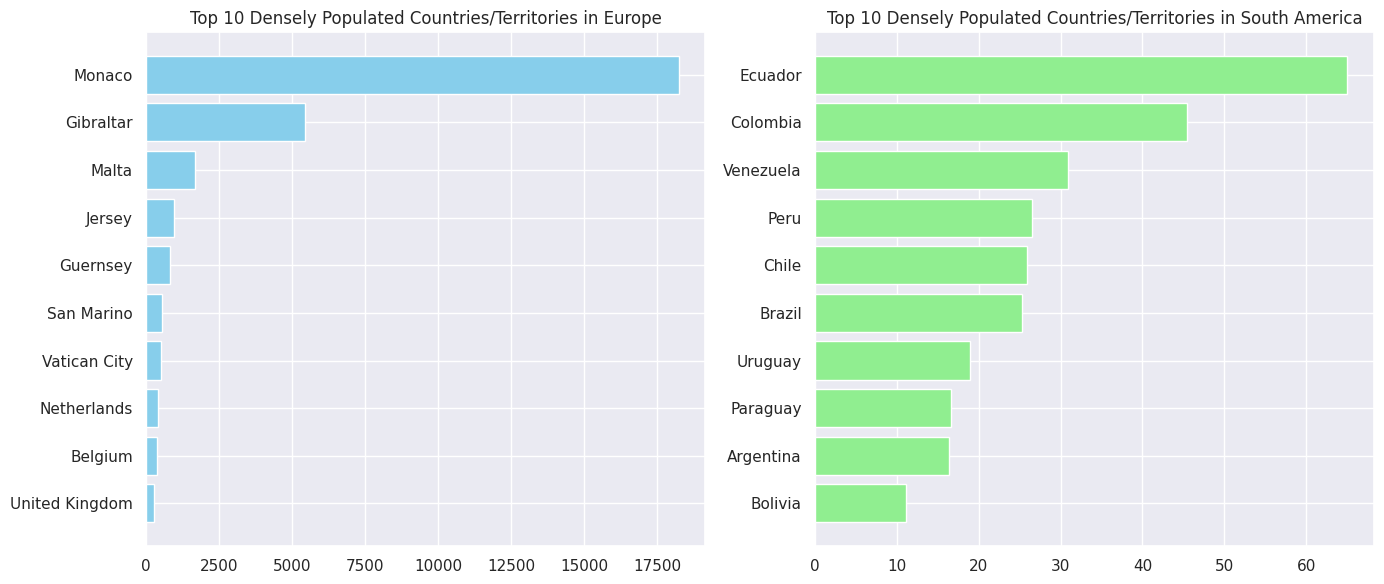

In [16]:
europe = population_data[population_data['Continent'] == 'Europe'].sort_values('Density__per_km__', ascending=False).head(10)
south_america = population_data[population_data['Continent'] == 'South America'].sort_values('Density__per_km__', ascending=False).head(10)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].barh(europe['Country_Territory'], europe['Density__per_km__'], color='skyblue')
axes[0].set_title('Top 10 Densely Populated Countries/Territories in Europe')
axes[0].invert_yaxis()

axes[1].barh(south_america['Country_Territory'], south_america['Density__per_km__'], color='lightgreen')
axes[1].set_title('Top 10 Densely Populated Countries/Territories in South America')
axes[1].invert_yaxis()  

plt.tight_layout()
plt.show()

### Population Growth from 1970 to 2022 for Top 10 Most Populous Countries

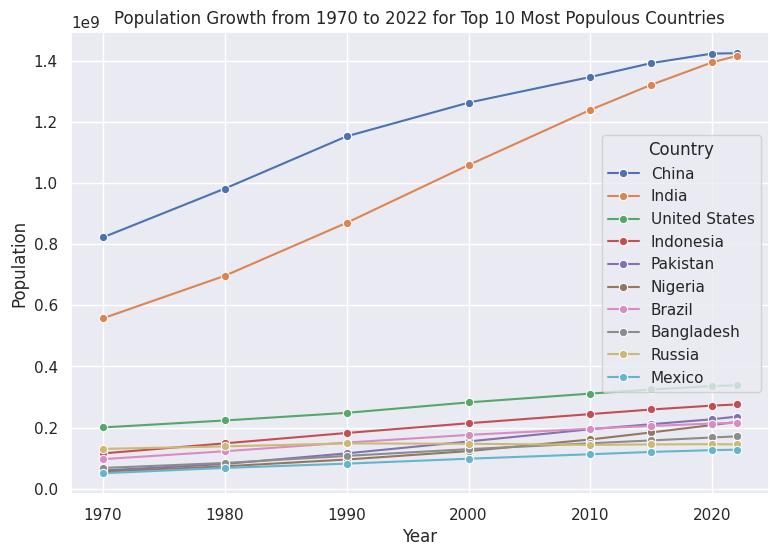

In [17]:
top_countries = population_data.sort_values(by='World_Population_Percentage', ascending=False).head(10)

data = pd.melt(top_countries,
               id_vars=['Country_Territory'],
               value_vars=['1970_Population', '1980_Population', '1990_Population', '2000_Population', '2010_Population', '2015_Population', '2020_Population', '2022_Population'],
               var_name='Year',
               value_name='Population')

data['Year'] = data['Year'].str.extract('(\d+)').astype(int)


plt.figure(figsize=(9, 6))
sns.lineplot(x='Year',
             y='Population',
             hue='Country_Territory',
             data=data, marker='o')

plt.title('Population Growth from 1970 to 2022 for Top 10 Most Populous Countries')
plt.legend(title='Country')
plt.show()